# Time series data

In this session we will demonstrate some of the many options of Pandas to import and manipulate time series data. The objective is to read data from two different sources and combine them to obtain a time series with daily values of water level, air temperature, relative humidity and rainfall.

As usual we start by importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will also select a time interval for the time series by defining the start and end dates. The `to_datetime` function converts the string provided to a `datetime64` data type, which is the underlying data type in Pandas for time series data. For more information see <A href="https://pandas.pydata.org/docs/user_guide/timeseries.html">https://pandas.pydata.org/docs/user_guide/timeseries.html</A>. Note that the `to_datetime` function can also accept other arguments than a string type, see <A href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html</A>.

In [2]:
t_min = pd.to_datetime("2013-08-25")
t_max = pd.to_datetime("2013-12-15")

Let's try to read the data in water_level_example.csv. The `read_csv` method has multiple options for figuring out the date and time based on the values provided in the file. One method that the documentation (<A href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html">https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html</A>) suggests is the following

In [4]:
df0 = pd.read_csv("data/water_level_example.csv", parse_dates=["Date", "Time"])
print(df0.head())

        Date                Time  ms     LEVEL  TEMPERATURE  CONDUCTIVITY
0 2013-08-25 2023-05-31 00:00:00   0  0.938222         10.6         0.205
1 2013-08-25 2023-05-31 01:00:00   0  0.937608         10.7         0.206
2 2013-08-25 2023-05-31 02:00:00   0  0.939127         10.8         0.206
3 2013-08-25 2023-05-31 03:00:00   0  0.934339         10.7         0.206
4 2013-08-25 2023-05-31 04:00:00   0  0.935828         10.7         0.206


However, that somehow does not seem to have worked: The 'Date' and 'Time' column appear exactly as they are in the file and the index is a series of integer numbers. What we wanted instead was the 'Date' and 'Time' columns to be merged into a single column that has the datetime64 data type. Since this has not worked we need to try something different (usually you'll try to look for an answer on <A href="https://stackoverflow.com/">https://stackoverflow.com/</A> in a situation like this one). For example

In [5]:
df0 = pd.read_csv("data/water_level_example.csv")
df0 = df0.set_index(pd.to_datetime(df0["Date"].astype(str) + " " + df0["Time"].astype(str)))
print(df0.head())

                           Date      Time  ms     LEVEL  TEMPERATURE  \
2013-08-25 00:00:00  2013/08/25  00:00:00   0  0.938222         10.6   
2013-08-25 01:00:00  2013/08/25  01:00:00   0  0.937608         10.7   
2013-08-25 02:00:00  2013/08/25  02:00:00   0  0.939127         10.8   
2013-08-25 03:00:00  2013/08/25  03:00:00   0  0.934339         10.7   
2013-08-25 04:00:00  2013/08/25  04:00:00   0  0.935828         10.7   

                     CONDUCTIVITY  
2013-08-25 00:00:00         0.205  
2013-08-25 01:00:00         0.206  
2013-08-25 02:00:00         0.206  
2013-08-25 03:00:00         0.206  
2013-08-25 04:00:00         0.206  


That looks more like it: The index now contains the datetime info. We can delete the original 'Date' and 'Time' columns to avoid storing redundant information. In fact, the 'ms' column doesn't look particularly useful, so let's also delete that one. The `drop` looks in the DataFrame's index by default, so it will delete rows for which a match is found with any of the names provided. Because we want to delete columns, and not rows, we have to override the default behaviour by passing `axis=1`.

In [6]:
df0 = df0.drop(["Date", "Time", "ms"], axis=1)
print(df0.head())

                        LEVEL  TEMPERATURE  CONDUCTIVITY
2013-08-25 00:00:00  0.938222         10.6         0.205
2013-08-25 01:00:00  0.937608         10.7         0.206
2013-08-25 02:00:00  0.939127         10.8         0.206
2013-08-25 03:00:00  0.934339         10.7         0.206
2013-08-25 04:00:00  0.935828         10.7         0.206


Let's plot the 'LEVEL' column to visualise the water level measurements.

<AxesSubplot:>

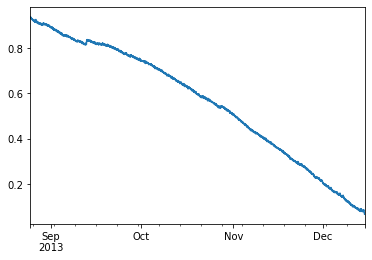

In [7]:
df0['LEVEL'].plot()

We can also zoom in to a shorter time period. Note that the dates can be passed as strings. Matplotlib understands these, which makes working with time series graphs a lot easier than it was years ago.

(383112.0, 383832.0)

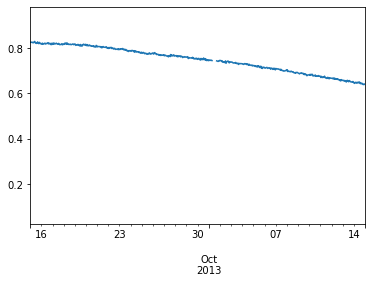

In [8]:
ax = df0['LEVEL'].plot()
ax.set_xlim("2013-09-15", "2013-10-15")

We notice that there is a gap in the data on the first of October. There are many ways to deal with missing data, but for this particular example it seems justifiable to use linear interpolation to fill the gap. Pandas provides the `interpolate` method for this, and all we have to do is call it without any arguments

(383112.0, 383832.0)

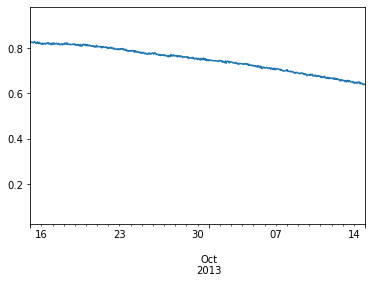

In [9]:
df0 = df0.interpolate()
ax = df0['LEVEL'].plot()
ax.set_xlim("2013-09-15", "2013-10-15")

Indeed the gap is gone. The values stored in the csv file are water heights above the pressure transducer, so they still need to be converted to water levels with respect to the reference marker on the jetty pole. We do this by shifting the data series by fitting it through the manual water level measurements in the fille `manual_readings.xlsx`, which are expressed with respect to the local reference point. Note that the manual measurements in the file are in cm above the reference point, so we divide by -100 to make sure they are in m and decrease in time, just like the water colum height measured by the transducer is decreasing with time.

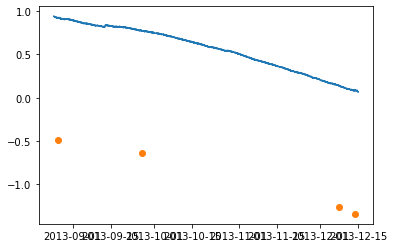

In [10]:
dfm = pd.read_excel("data/manual_readings.xlsx", index_col=0, parse_dates=True)
# df0['LEVEL'] = -df0['LEVEL']
df0['manual'] = dfm / -100.

fig, ax = plt.subplots()
ax.plot(df0.index, df0['LEVEL'])
ax.plot(df0.index, df0['manual'], 'o')

One way to calcuate the required offset is to calculate the mean of the differences between the manual and the pressure transducer readings. Note that the column `manual` in `df0` contains many NaN values, so the `nanmean` method from NumPy is used so that these are ignored in calculating the mean.

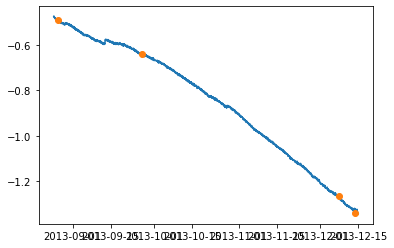

In [11]:
wl_offset = np.nanmean(df0['manual'] - df0['LEVEL'])

fig, ax = plt.subplots()
ax.plot(df0.index, wl_offset + df0['LEVEL'])
ax.plot(df0.index, df0['manual'], 'o')

Now that the water levels are stored in the right way, we can move on to read the weather data. The problem to tackle with these is that they are spread across multiple worksheets in an Excel file, with each worksheet containing the data of a particular month. Fortunately it is not too difficult to merge the data from the various sheets into a single DataFrame. The first thing to do is to call the Pandas method `read_excel` and explicitly pass `sheet_name=None` as an argument. Note that the other two arguments ensure that the dates are parsed correctly.

In [12]:
sheets_dict = pd.read_excel(
    "data/weather_data_by_month.xlsx", 
    index_col=0, 
    parse_dates=True,
    sheet_name=None,
)

The effect of passing `sheet_name=None` is that `read_excel` returns a dictionary with the worksheets. Each worksheet is read as a DataFrame and is accessible in the dictionary by passing the sheet name as a key. So by iterating over the dictionary items, we can grab each DataFrame. By defining an empty DataFrame first, each DataFrame from `sheets_dict` can be appended using the `concat` function to create the DataFrame with all the data.

In [13]:
dfd = pd.DataFrame()
for sheet_name, df in sheets_dict.items():
    dfd = pd.concat((dfd, df))

Now let's trim the DataFrame with weather data to the period of interest

In [14]:
idx = (dfd.index >= t_min) & (dfd.index <= t_max)
dfd = dfd.loc[idx]

We can combine the weather data with the water level data if we keep in mind that the water levels were reported at hourly intervals, so they must be resampled to daily values. For this, Pandas provides the `resample` function, which is called here with the argument `1D`, which indicates that the measurements need to be aggregated at a one-day interval. The `.mean()` at the end indicates that the values need to be averaged. These daily averages can be added as a new column to `dfd`

In [15]:
dfwl = wl_offset + df0["LEVEL"].resample('1D').mean()
dfd['wl'] = dfwl

By loading the coefficients of the polynomials that calculate dam area and volume based on the water level (from session 3), we can convert the measured water levels to water surface area and volume, and add these as new columns to the DataFrame.

In [37]:
# p_func_V = np.poly1d(np.loadtxt("p_coef_V_linear.dat"))
# p_func_A = np.poly1d(np.loadtxt("p_coef_A_linear.dat"))

# dfd["volume"] = p_func_V(dfd["wl"])
# dfd["area"] = p_func_A(dfd["wl"])


In [18]:
#some interesting things:
#print(dfd.index.duplicated())
#returns boolian list

Finally, the data can be saved to an Excel file using `to_excel`.

In [17]:
dfd.to_excel("daily_wl&meteo_data.xlsx")

## Homework: Vapour pressure deficit

The evaporative demand of the atmosphere depends on the vapour pressure deficit ($vpd$), which is the difference between the saturation vapour pressure $e_s$ and the actual vapour pressure ($e_a$):

$vpd = e_s - e_a$

where 

$ e_a = \frac{rh}{100} e_s$

in which $rh$ is the relative humidity in percent, and 

$ e_s = 0.6108 e^{\frac{17.27 T}{T + 237.3}}$

In the equations above $vpd$, $e_a$ and $e_s$ are expressed kPa and the temperature $T$ is in °C. For more details see <A href="https://www.fao.org/3/x0490e/x0490e07.htm">https://www.fao.org/3/x0490e/x0490e07.htm</A>.

***Exercise***: Use the equations above to calculate the $vpd$ with the available temperature and relative humidity data. Add the result as a column to the DataFrame `dfd` and save the DataFrame to an Excel file.

In [30]:
dfd['es'] = 0.6108*np.exp (17.27*dfd['temperature']/(dfd['temperature']+273.3))


In [31]:
dfd['ea'] = dfd['rh']*dfd['es']/100

In [33]:
dfd['vpd'] = dfd['es'] - dfd['ea']

In [35]:
dfd = dfd.drop(["es", "ea"], axis=1)
dfd.head()

,temperature,rh,rain,wl,vpd
2013-08-25,11.25,81.0,0.0,-0.481333,0.229712
2013-08-26,10.75,89.5,0.4,-0.491695,0.123293
2013-08-27,13.75,71.0,0.0,-0.498408,0.405105
2013-08-28,14.00,83.0,0.0,-0.505052,0.240898
2013-08-29,14.10,84.5,6.8,-0.505966,0.220901


In [36]:
dfd.to_excel("daily_wl&meteo&vpd_data.xlsx")